In [1]:
import sys
sys.path.append('..')
import itertools, copy
import re
import json
import numpy as np
import scipy.misc
from scipy.stats import binom
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.style.use('../peptidome.mplstyle')

from lib import *
from lib.maxent import *

%load_ext autoreload
%autoreload 2

In [2]:
humanseqs = [s for s in fasta_iter(human, returnheader=False)]


In [3]:
train, test = train_test_split(humanseqs, test_size=0.5)


In [4]:
k = 3


In [5]:
kmers = [''.join(s) for s in itertools.product(aminoacids, repeat=k)]
df = pd.DataFrame.from_dict(dict(seq=kmers, freq=np.zeros(len(kmers))))
df.set_index('seq', inplace=True)
df['freq'] = df.add(count(train, k), fill_value=0.0)
df['freq_test'] = np.zeros(len(kmers))
df['freq_test'] = df['freq_test'].add(count(test, k)['freq'], fill_value=0.0)
jsd_test = calc_jsd(df['freq_test'], df['freq'])
jsd_flat = calc_jsd(df['freq_test'], np.ones_like(df['freq']), base=2)


#df_test.set_index('seq', inplace=True)
#df_count = counter_to_df(count_kmers_iterable(test, k), norm=False)
#df_count.set_index('seq', inplace=True)
#df_test = df_test.add(df_count, fill_value=0.0)
#df_test['freq'] = df_test['count'] / np.sum(df_test['count'])


tripletparams = calc_tripletmodelparams(train)
#kmers = df.index
df['freq_ind'] = np.array([10**(loglikelihood_independent(s, **tripletparams)) for s in kmers])
df['freq_mc'] = np.array([10**(loglikelihood_mc(s, **tripletparams)) for s in kmers])
df['freq_tri'] = np.array([10**(loglikelihood_triplet(s, **tripletparams)) for s in kmers])
jsd_ind = calc_jsd(df['freq_test'], df['freq_ind'], base=2)
jsd_mc = calc_jsd(df['freq_test'], df['freq_mc'], base=2)
jsd_tri = calc_jsd(df['freq_test'], df['freq_tri'], base=2)

In [6]:
aacountss = []
#for seq in np.random.choice(humanseqs, 1000, replace=False):
for seq in train:
    seq = seq.strip('X')
    if not isvalidaa(seq):
        seq = re.sub('X|U', '', seq)
        if not isvalidaa(seq):
            print(seq)
    seq = map_aatonumber(seq)
    for i in range(len(seq)-k):
        #if isvalidaa(seq[i:i+k]):
        #print(seq[i:i+k], aacounts(seq[i:i+k]))
        aacountss.append(aacounts_int(seq[i:i+k]))

A 0.07018196319094387 [0.80916578 0.17231273 0.0173313  0.00119019]
C 0.0230518411129529 [9.33056429e-01 6.47747237e-02 2.12573121e-03 4.31157313e-05]
D 0.04751265640647439 [8.65330503e-01 1.27051639e-01 7.36723431e-03 2.50623661e-04]
E 0.07104289911013449 [0.80831139 0.17162396 0.01868921 0.00137544]
F 0.03642254924194759 [8.95360441e-01 1.00090155e-01 4.47071103e-03 7.86935267e-05]
G 0.0651804495280772 [8.19793028e-01 1.65643908e-01 1.37917429e-02 7.71321347e-04]
H 0.026185023932931942 [9.24073474e-01 7.33913854e-02 2.44172513e-03 9.34153731e-05]
I 0.043559198005213164 [8.75960026e-01 1.17522398e-01 6.39752031e-03 1.20054905e-04]
K 0.05764134520755409 [8.40720483e-01 1.46186534e-01 1.25414375e-02 5.51545212e-04]
L 0.09976095693871588 [0.73159094 0.23897938 0.02798553 0.00144414]
M 0.02024943247866004 [9.40738078e-01 5.77927128e-02 1.45203148e-03 1.71772400e-05]
N 0.03617338783220694 [8.95955799e-01 9.96479737e-02 4.31648216e-03 7.97450872e-05]
P 0.06315935031790425 [0.82867275 0.1543

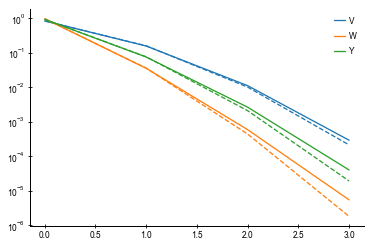

In [44]:
pseudocount = 1e-2
aafreqs = np.mean(np.asarray(aacountss), axis=0)/k
prob_aa_ks = prob_aa(aacountss, k, pseudocount=pseudocount)
for i in range(len(aminoacids)):
    aa = map_numbertoaa([i])[0]
    prob_aa_k = prob_aa_ks[i]
    print(aa, aafreqs[i], prob_aa_k)
    if i >16:
        l, = plt.plot(prob_aa_k, label=aa)
        x = np.arange(0, k+1, 1)
        n = k
        p = aafreqs[i]
        plt.plot(x, binom.pmf(x, n, p), '--', c=l.get_color())
plt.legend()
plt.yscale('log')
fks = np.asarray(prob_aa_ks)

In [45]:
for i, aa in enumerate(aminoacids):
    dist = scipy.stats.rv_discrete(values=(np.arange(k+1), prob_aa_ks[i]))
    print(aa, dist.var()/(dist.mean()*(1-dist.mean()/k)))

A 1.0625771941793762
C 1.0195649023022253
D 1.0198392910670318
E 1.077522672501814
F 1.0138094683680006
G 1.036764862445943
H 1.0173861616040063
I 1.0170495603845016
K 1.0518972712591002
L 1.0182700744915758
M 1.0091885943746781
N 1.0120498490975285
P 1.0830176561123857
Q 1.0377695511885143
R 1.0465291072434337
S 1.0624230391457272
T 1.0231977957502412
V 1.0150855582618494
W 1.0088789308278159
Y 1.0156053703525478


In [8]:
# evaluate empirical observables for fitting
df0 = count(train, 1)
df1 = count(train, 2, gap=0)
dfgap1 = count(train, 2, gap=1)
if k == 4:
    dfgap2 = count(train, 2, gap=2)

In [9]:
args = [df1, dfgap1, dfgap2] if k == 4 else [df1, dfgap1]
h, Jk = fit_ising(df0, args, nmcmc=5e5, niter=10, epsilon=0.2, N=k, output=True)

[ 0.45372895 -0.65964851  0.06305901  0.46478129 -0.20277892  0.37814671
 -0.53260975 -0.0245608   0.25711263  0.80430225 -0.73222319 -0.20974447
  0.34726576  0.0645158   0.23295415  0.62676144  0.18877261  0.29108636
 -1.29886505 -0.51205627]
iteration 0
f1 6.4331098127172665e-06
f2, gap 0 0.002384177887086923
f2, gap 1 0.001963444279899073
iteration 1
f1 5.311625918338817e-06
f2, gap 0 0.0017391698645377244
f2, gap 1 0.0013212536337933634
iteration 2
f1 1.1357785609720052e-05
f2, gap 0 0.0011039446554275954
f2, gap 1 0.0009683778291910818
iteration 3
f1 1.2602404368973092e-05
f2, gap 0 0.0007024574157963314
f2, gap 1 0.0007356535850437341
iteration 4
f1 8.006796881827585e-06
f2, gap 0 0.0005425770284775988
f2, gap 1 0.0005897652759192061
iteration 5


KeyboardInterrupt: 

In [ ]:
Z = np.exp(scipy.special.logsumexp([-clib.energy(np.array(s), h, Jk) for s in itertools.product(range(naminoacids), repeat=k)]))
df['freq_maxent'] = np.exp([-clib.energy(map_aatonumber(s), h, Jk) for s in kmers])/Z
jsd_maxent = calc_jsd(df_test['freq'], df['freq_maxent'], base=2)

In [ ]:
hks = fit_global(fks, niter=10, nmcmc=1e6, epsilon=0.1, output=True)

In [ ]:
pseudocount = 1e-2
niter=10
nmcmc=1e6
epsilon=0.5
prng=None
output=False

N = len(fks[0])-1
if prng is None:
    prng = np.random
q = len(aminoacids)
aas_arr = np.array(list(aminoacids))
f1 = np.sum(np.arange(fks.shape[1])*fks, axis=1)/(fks.shape[1]-1)
h = np.array(np.log(f1))
h -= np.mean(h)
hks = h.reshape(20, 1)*np.arange(fks.shape[1])
#hks = np.zeros((q, N+1))
for i in range(niter):
    if output:
        print('iteration %g'%i)
#    def jump(x):
#        xp = x.copy()
#        i = np.random.randint(0, len(x))
#        xp[i] = (xp[i]+np.random.randint(0, q-1))%q
#        return xp
    def jump(x):
        return prng.randint(q, size=N)
    def energy(x):
        return energy_global(aacounts_int(x), hks)
    x0 = jump(prng.randint(q, size=N))
    samples = mcmcsampler(x0, energy, jump, nmcmc, prng=prng, nburnin=1e3)
    aacountss = [aacounts_int(s) for s in samples]
    prob_aa_ks = prob_aa(aacountss, N, pseudocount=pseudocount)
    #Z = np.exp(scipy.special.logsumexp([-energy_global(aacounts_int(np.array(s)), hks) for s in itertools.product(range(naminoacids), repeat=k)]))
    #probs = np.exp([-energy_global(aacounts(s), hks) for s in kmers])/Z
    if i == 0:
        prob_aa_ks0 = prob_aa_ks
    hks += np.log(fks/prob_aa_ks)*epsilon
    #hks += (fks-prob_aa_ks)*epsilon
    jsd = calc_jsd(fks, prob_aa_ks, base=2)
    print(jsd)

In [ ]:
plt.plot(fks.flatten(), prob_aa_ks.flatten(), 'o')
x = [1e-6, 1e0]
plt.plot(x, x, 'k')
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(fks.flatten(), prob_aa_ks0.flatten()/fks.flatten(), 'o')
plt.plot(fks.flatten(), prob_aa_ks.flatten()/fks.flatten(), 'o')
#x = [1e-6, 1e0]
#plt.plot(x, x, 'k')
plt.axhline(1.0, c='k')
#plt.ylim(1e-1)
plt.xscale('log')
plt.yscale('log')

In [ ]:
Z = np.exp(scipy.special.logsumexp(
           [-energy_global(aacounts_int(np.array(s)), hks) for s in itertools.product(range(naminoacids), repeat=k)]
           ))
df['freq_maxentglobal'] = np.exp([-energy_global(aacounts(s), hks) for s in kmers])/Z
jsd_maxentglobal = calc_jsd(df['freq_test'], df['freq_maxentglobal'], base=2)

In [ ]:
entropies = {}
Smax = np.log2(20)*k
for column in df.filter(regex='freq'):
    f3 = np.array(df[column])
    entropy = scipy.stats.entropy(f3, base=2)
    print(column, Smax-entropy)
    entropies[column] = entropy

In [ ]:
print('test', jsd_test, 'maxent', jsd_maxent, 'maxentglobal', jsd_maxentglobal,
              'flat', jsd_flat, 'ind', jsd_ind, 'mc', jsd_mc, 'tri', jsd_tri)

In [ ]:
from scipy.interpolate import interpn

def density_scatter(x, y, ax=None, sort=True, bins=20, trans=None, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        ax = plt.gca()
    if trans is None:
        trans = lambda x: x
    data , x_e, y_e = np.histogram2d(trans(x), trans(y), bins = bins)
    z = interpn(( 0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1]) ),
                data, np.vstack([trans(x),trans(y)]).T,
                method="splinef2d", bounds_error=False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)
    return ax

In [ ]:
from scipy.stats import gaussian_kde
def scatterplot(x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    ax.scatter(x, y, c=z, s=1, edgecolor='')

In [ ]:
scatter = lambda x, y, ax: density_scatter(x, y, ax=ax, s=1, bins=100,
                                           trans=lambda x: np.log(x+1e-8),
                                           norm=matplotlib.colors.LogNorm(vmin=0.5, vmax=50 if k ==3 else 400),
                                           cmap='viridis')
#scatter = lambda x, y, ax: ax.scatter(x, y, s=1, alpha=1, edgecolor=None)

fig, axes = plt.subplots(figsize=(7.2, 2.0), ncols=5, sharex=True, sharey=True)
axes[0].set_ylabel('test set')

for ax, column, xlabel in [(axes[0], 'freq_ind','independent prediction'),
                           (axes[1], 'freq_maxentglobal', 'global maxent prediction'),
                           (axes[2], 'freq_mc', 'mc'),
                           (axes[3], 'freq_maxent', 'maxent prediction'),
                           (axes[4], 'freq', 'training set')
                            ]:
    scatter(df[column], df['freq_test'], ax)
    ax.set_xlabel(xlabel)
    jsd = calc_jsd(df['freq_test'], df[column], base=2)
    entropy = entropies[column]
    ax.set_title('JSD = {:.4f}\nH = {:.2f}'.format(jsd, entropy))
    
if k == 3:
    x = np.logspace(-5.7, -2.7)
elif k == 4:
    x = np.logspace(-7.7, -2.9)
for ax in axes:
    ax.plot(x, x, 'k', lw=0.8)
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(x), max(x))
    ax.set_xscale('log')
    ax.set_yscale('log')
fig.tight_layout()
fig.savefig('main.png' if k == 3 else 'comparison_k4.png', dpi=600)

In [ ]:
2**entropies['freq'], 2**entropies['freq_maxent'], 2**entropies['freq_ind'], 20**k

In [ ]:
bins = np.linspace(-6, -2)
kwargs = dict(bins=bins, histtype='step')
plt.hist(np.log10(df['freq_ind']), **kwargs)
plt.hist(np.log10(df['freq_maxent']),**kwargs)
plt.hist(np.log10(df['freq']),**kwargs)
plt.yscale('log')